In [1]:
# 本番提出用
# 9/16以降の直近1週間で計算する
# validのデータは使わず、notebook内でMAPの計算はしない

In [2]:
import numpy as np
import pandas as pd
import gc
import os
import time
import random
from tqdm.auto import tqdm

In [3]:
def visualize_df(df):
    print(df.shape)
    display(df.head())

In [4]:
# parameter
val_start_date = '2020-09-16'
topk = 50

In [5]:
from datetime import datetime, date, timedelta
val_end_date = pd.to_datetime(val_start_date) + timedelta(days=7)

In [6]:
val_end_date = str(val_end_date.strftime('%Y-%m-%d'))
print(val_start_date, val_end_date)

2020-09-16 2020-09-23


In [7]:
# データの読み込み
dir = 'h-and-m-personalized-fashion-recommendations/'
path = '../input/' + dir 

#customers = pd.read_csv(path + 'customers.csv')
#articles = pd.read_csv(path + 'articles.csv')
transactions_train = pd.read_csv(path + 'transactions_train.csv')

In [8]:
# save memory https://www.kaggle.com/c/h-and-m-personalized-fashion-recommendations/discussion/308635
# 64文字もあるが、末尾16文字だけでcustomerを一意にid可能
# 使われている文字は0-9, a-fなので16進数で変換してintで扱える
# 16進数 = 4bit, 4bit * 16 / 8 = 8 byte
# 64 byte -> 8 byteに削減, int64で表現可能
transactions_train['customer_id'] = transactions_train['customer_id'].apply(lambda x: int(x[-16:],16) ).astype('int64')
# メモリ削減
transactions_train['article_id'] = transactions_train['article_id'].astype('int32')

In [9]:
sub = pd.read_csv(path + 'sample_submission.csv')
del sub['prediction']; gc.collect()
visualize_df(sub)

(1371980, 1)


,customer_id
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...


In [10]:
sub['customer_id'] = sub['customer_id'].apply(lambda x: int(x[-16:],16) ).astype('int64')

In [11]:
visualize_df(transactions_train)

(31788324, 5)


,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,-6846340800584936,663713001,0.050831,2
1,2018-09-20,-6846340800584936,541518023,0.030492,2
2,2018-09-20,-8334631767138808638,505221004,0.015237,2
3,2018-09-20,-8334631767138808638,685687003,0.016932,2
4,2018-09-20,-8334631767138808638,685687004,0.016932,2


In [12]:
# 提出サンプルの確認
sub.head()

,customer_id
0,6883939031699146327
1,-7200416642310594310
2,-6846340800584936
3,-94071612138601410
4,-283965518499174310


### Divide data

In [13]:
# transactions_train['t_dat'].unique()[-7:]

# array(['2020-09-16', '2020-09-17', '2020-09-18', '2020-09-19',
#       '2020-09-20', '2020-09-21', '2020-09-22'], dtype=object)


In [14]:
train_data = transactions_train.query(f"'{val_start_date}' <= t_dat and t_dat < '{val_end_date}'").reset_index(drop=True)
visualize_df(train_data)

(240311, 5)


,t_dat,customer_id,article_id,price,sales_channel_id
0,2020-09-16,8055340703569116761,786022008,0.048441,2
1,2020-09-16,8055340703569116761,913272003,0.032288,2
2,2020-09-16,8055340703569116761,889669006,0.056508,2
3,2020-09-16,2563761487478961358,237347060,0.033881,1
4,2020-09-16,2563761487478961358,562245001,0.013542,1


### customer_data

In [15]:
customers = pd.read_csv(path + 'customers.csv')
customers['customer_id'] = customers['customer_id'].apply(lambda x: int(x[-16:],16) ).astype('int64')
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,6883939031699146327,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,-7200416642310594310,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,-6846340800584936,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,-94071612138601410,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,-283965518499174310,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [16]:
customers = customers[['customer_id','age']]
customers.head()

,customer_id,age
0,6883939031699146327,49.0
1,-7200416642310594310,25.0
2,-6846340800584936,24.0
3,-94071612138601410,54.0
4,-283965518499174310,52.0


In [17]:
customers.describe()

,customer_id,age
count,1.371980e+06,1.356119e+06
mean,-8.899354e+15,3.638696e+01
std,5.326640e+18,1.431363e+01
min,-9.223353e+18,1.600000e+01
25%,-4.624561e+18,2.400000e+01
50%,-1.147651e+16,3.200000e+01
75%,4.602000e+18,4.900000e+01
max,9.223371e+18,9.900000e+01


In [18]:
# 年齢がないものは0歳としておく (''だと後からintにcastできないため)
train_data = pd.merge(train_data, customers, on='customer_id', how='left').fillna('0')

In [19]:
train_data.dtypes

t_dat                object
customer_id           int64
article_id            int32
price               float64
sales_channel_id      int64
age                  object
dtype: object

In [20]:
train_data['age'].value_counts()

25.0    12235
26.0    12182
24.0    12136
23.0    10778
27.0    10544
        ...  
88.0        4
90.0        3
98.0        2
94.0        1
92.0        1
Name: age, Length: 78, dtype: int64

In [21]:
train_data['age'] = train_data['age'].astype('int32')
train_data.dtypes

t_dat                object
customer_id           int64
article_id            int32
price               float64
sales_channel_id      int64
age                   int32
dtype: object

### 単純なランキングから上位50件を取ってくる

In [22]:
# -30, 30-40, 40-50, 50-
train_sort_30 = train_data.query('age < 30').groupby('article_id', as_index=False).count().sort_values('customer_id', ascending=False)
train_sort_40 = train_data.query('30 <= age and age < 40').groupby('article_id', as_index=False).count().sort_values('customer_id', ascending=False)
train_sort_50 = train_data.query('40 <= age and age < 50').groupby('article_id', as_index=False).count().sort_values('customer_id', ascending=False)
train_sort_60 = train_data.query('50 <= age').groupby('article_id', as_index=False).count().sort_values('customer_id', ascending=False)

In [23]:
#popular_list = train_sort.head(100)['article_id'].tolist()

In [24]:
#popular_list_under40 = train_sort_under40.head(100)['article_id'].tolist()
#popular_list_over40 = train_sort_over40.head(100)['article_id'].tolist()

In [25]:
popular_list_30 = train_sort_30.head(topk)['article_id'].tolist()
popular_list_40 = train_sort_40.head(topk)['article_id'].tolist()
popular_list_50 = train_sort_50.head(topk)['article_id'].tolist()
popular_list_60 = train_sort_60.head(topk)['article_id'].tolist()

### Visualize

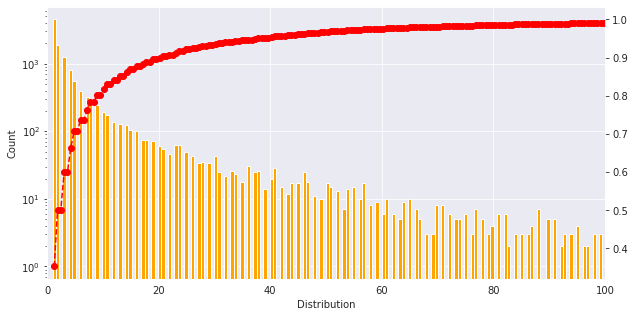

In [26]:
# 30
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data=train_sort_30, x='customer_id', bins=700, color='orange')
ax.set_xlabel('Distribution')
plt.yscale('log')
plt.xlim(0, 100)


# ヒストグラムプロットとビン情報の取得
#n, bins, patches = ax.hist(dt, alpha=0.7, label='Frequency')
n, bins, patches = ax.hist(data=train_sort_30, x='customer_id', bins=700, color='orange')

# 第2軸用値の算出
y2 = np.add.accumulate(n) / n.sum()
x2 = np.convolve(bins, np.ones(2) / 2, mode="same")[1:]
# 第2軸のプロット
ax2 = ax.twinx()
lines = ax2.plot(x2, y2, ls='--', color='r', marker='o',
         label='Cumulative ratio')
ax2.grid(visible=False)

plt.show()

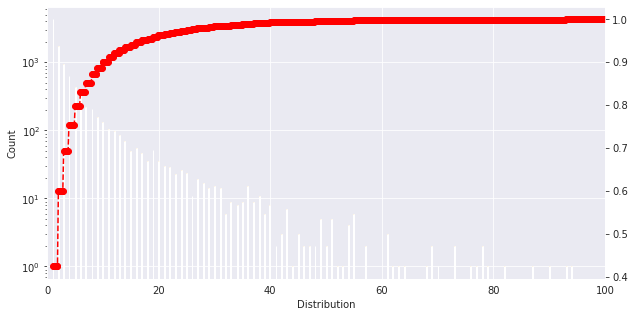

In [27]:
# 30 - 40
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data=train_sort_40, x='customer_id', bins=700, color='orange')
ax.set_xlabel('Distribution')
plt.yscale('log')
plt.xlim(0, 100)


# ヒストグラムプロットとビン情報の取得
#n, bins, patches = ax.hist(dt, alpha=0.7, label='Frequency')
n, bins, patches = ax.hist(data=train_sort_40, x='customer_id', bins=700, color='orange')

# 第2軸用値の算出
y2 = np.add.accumulate(n) / n.sum()
x2 = np.convolve(bins, np.ones(2) / 2, mode="same")[1:]
# 第2軸のプロット
ax2 = ax.twinx()
lines = ax2.plot(x2, y2, ls='--', color='r', marker='o',
         label='Cumulative ratio')
ax2.grid(visible=False)

plt.show()

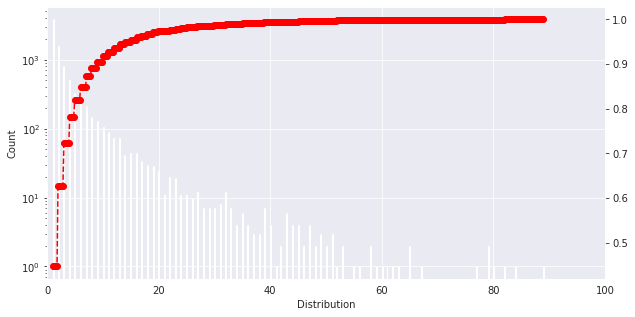

In [28]:
# 40 - 50

sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data=train_sort_50, x='customer_id', bins=500, color='orange')
ax.set_xlabel('Distribution')
plt.yscale('log')
plt.xlim(0, 100)


# ヒストグラムプロットとビン情報の取得
#n, bins, patches = ax.hist(dt, alpha=0.7, label='Frequency')
n, bins, patches = ax.hist(data=train_sort_50, x='customer_id', bins=500, color='orange')

# 第2軸用値の算出
y2 = np.add.accumulate(n) / n.sum()
x2 = np.convolve(bins, np.ones(2) / 2, mode="same")[1:]
# 第2軸のプロット
ax2 = ax.twinx()
lines = ax2.plot(x2, y2, ls='--', color='r', marker='o',
         label='Cumulative ratio')
ax2.grid(visible=False)

plt.show()

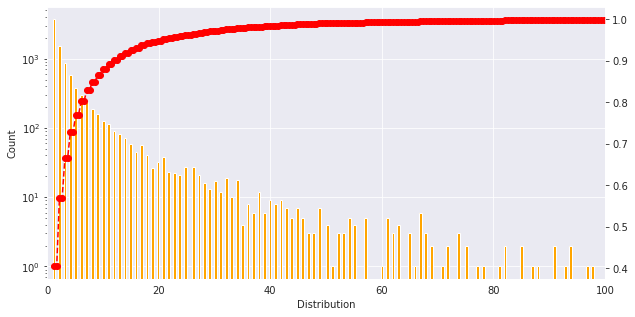

In [29]:
# 50 - 

sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data=train_sort_60, x='customer_id', bins=500, color='orange')
ax.set_xlabel('Distribution')
plt.yscale('log')
plt.xlim(0, 100)


# ヒストグラムプロットとビン情報の取得
#n, bins, patches = ax.hist(dt, alpha=0.7, label='Frequency')
n, bins, patches = ax.hist(data=train_sort_60, x='customer_id', bins=500, color='orange')

# 第2軸用値の算出
y2 = np.add.accumulate(n) / n.sum()
x2 = np.convolve(bins, np.ones(2) / 2, mode="same")[1:]
# 第2軸のプロット
ax2 = ax.twinx()
lines = ax2.plot(x2, y2, ls='--', color='r', marker='o',
         label='Cumulative ratio')
ax2.grid(visible=False)

plt.show()

### Popular list

In [30]:
#popular_list
popular_list_30

[924243001,
 918522001,
 866731001,
 448509014,
 909370001,
 924243002,
 915529005,
 923758001,
 918292001,
 934835001,
 762846027,
 929275001,
 915529003,
 714790020,
 889550002,
 788575004,
 865799006,
 915526001,
 935541001,
 751471001,
 573085028,
 850917001,
 909059002,
 911699002,
 788575002,
 863583001,
 896169005,
 715624001,
 894780001,
 573085042,
 706016001,
 898692006,
 673677002,
 881942001,
 706016003,
 919273002,
 781613006,
 827968001,
 918525001,
 791587001,
 898713001,
 893432002,
 873279005,
 898694001,
 870328003,
 799365001,
 926502001,
 918292004,
 874110016,
 863646001]

In [31]:
cnt=0
for i in popular_list_30:
    if i in popular_list_60:
        cnt+= 1
print('ratio=', cnt/100)

cnt=0
for i in popular_list_30[:50]:
    if i in popular_list_60[:50]:
        cnt+= 1
print('ratio 50=', cnt/50)

ratio= 0.2
ratio 50= 0.4


In [32]:
popular_str_30 = ['0'+ str(i) for i in popular_list_30]
popular_str_40 = ['0'+ str(i) for i in popular_list_40]
popular_str_50 = ['0'+ str(i) for i in popular_list_50]
popular_str_60 = ['0'+ str(i) for i in popular_list_60]

In [33]:
join_popular_30 = ' '.join(popular_str_30)
join_popular_40 = ' '.join(popular_str_40)
join_popular_50 = ' '.join(popular_str_50)
join_popular_60 = ' '.join(popular_str_60)

In [34]:
join_popular_30

'0924243001 0918522001 0866731001 0448509014 0909370001 0924243002 0915529005 0923758001 0918292001 0934835001 0762846027 0929275001 0915529003 0714790020 0889550002 0788575004 0865799006 0915526001 0935541001 0751471001 0573085028 0850917001 0909059002 0911699002 0788575002 0863583001 0896169005 0715624001 0894780001 0573085042 0706016001 0898692006 0673677002 0881942001 0706016003 0919273002 0781613006 0827968001 0918525001 0791587001 0898713001 0893432002 0873279005 0898694001 0870328003 0799365001 0926502001 0918292004 0874110016 0863646001'

In [35]:
# subにcustomerをjoin
sub2 =  pd.merge(sub, customers, on='customer_id', how='left').fillna('0')
sub2['age'] = sub2['age'].astype('int32')

In [36]:
sub2

,customer_id,age
0,6883939031699146327,49
1,-7200416642310594310,25
2,-6846340800584936,24
3,-94071612138601410,54
4,-283965518499174310,52
...,...,...
1371975,7551062398649767985,24
1371976,-9141402131989464905,21
1371977,-8286316756823862684,21
1371978,2551401172826382186,18


In [37]:
sub2_30 = sub2.query('age < 30')
sub2_40 = sub2.query('30 <= age and age < 40')
sub2_50 = sub2.query('40 <= age and age < 50')
sub2_60 = sub2.query('50 <= age')

In [38]:
sub2_30['prediction'] = join_popular_30
sub2_40['prediction'] = join_popular_40
sub2_50['prediction'] = join_popular_50
sub2_60['prediction'] = join_popular_60

<ipython-input-38-aeda923c6b9b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub2_30['prediction'] = join_popular_30
<ipython-input-38-aeda923c6b9b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub2_40['prediction'] = join_popular_40
<ipython-input-38-aeda923c6b9b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

In [39]:
sub = sub2_30.append(sub2_40, ignore_index=True)
sub = sub.append(sub2_50, ignore_index=True)
sub = sub.append(sub2_60, ignore_index=True)

<ipython-input-39-83e0f94d1b8b>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sub = sub2_30.append(sub2_40, ignore_index=True)
<ipython-input-39-83e0f94d1b8b>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sub = sub.append(sub2_50, ignore_index=True)
<ipython-input-39-83e0f94d1b8b>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sub = sub.append(sub2_60, ignore_index=True)


In [40]:
sub

,customer_id,age,prediction
0,-7200416642310594310,25,0924243001 0918522001 0866731001 0448509014 09...
1,-6846340800584936,24,0924243001 0918522001 0866731001 0448509014 09...
2,-2477030216582433370,0,0924243001 0918522001 0866731001 0448509014 09...
3,-3402710142238164438,20,0924243001 0918522001 0866731001 0448509014 09...
4,5669685583838440396,20,0924243001 0918522001 0866731001 0448509014 09...
...,...,...,...
1371975,8959640756044895752,55,0924243001 0930380001 0924243002 0928206001 09...
1371976,8536186189414498976,53,0924243001 0930380001 0924243002 0928206001 09...
1371977,-1244504865876165278,51,0924243001 0930380001 0924243002 0928206001 09...
1371978,5823894334162843119,52,0924243001 0930380001 0924243002 0928206001 09...


### Submit

In [41]:
print(sub.shape)

(1371980, 3)


In [42]:
sub = sub.drop(columns='age')
sub

,customer_id,prediction
0,-7200416642310594310,0924243001 0918522001 0866731001 0448509014 09...
1,-6846340800584936,0924243001 0918522001 0866731001 0448509014 09...
2,-2477030216582433370,0924243001 0918522001 0866731001 0448509014 09...
3,-3402710142238164438,0924243001 0918522001 0866731001 0448509014 09...
4,5669685583838440396,0924243001 0918522001 0866731001 0448509014 09...
...,...,...
1371975,8959640756044895752,0924243001 0930380001 0924243002 0928206001 09...
1371976,8536186189414498976,0924243001 0930380001 0924243002 0928206001 09...
1371977,-1244504865876165278,0924243001 0930380001 0924243002 0928206001 09...
1371978,5823894334162843119,0924243001 0930380001 0924243002 0928206001 09...


In [43]:
# backfill用のcsv書き出し、上位50件、直近1週間
sub.to_csv(f'simple_ranking_{val_start_date}_{topk}.csv', index=False)